Overlap mask: True
NaNs in dDEM: 0
Memory used: 13.63 GB
Memory used: 13.63 GB


/projects/ak120175@colostate.edu/software/anaconda/envs/xdem_env/lib/python3.10/site-packages/xdem/volume.py:380: UserWarning: No valid data found within mask, returning copy
  warnings.warn("No valid data found within mask, returning copy", UserWarning)
/projects/ak120175@colostate.edu/software/anaconda/envs/xdem_env/lib/python3.10/site-packages/xdem/volume.py:380: UserWarning: No valid data found within mask, returning copy
  warnings.warn("No valid data found within mask, returning copy", UserWarning)
/projects/ak120175@colostate.edu/software/anaconda/envs/xdem_env/lib/python3.10/site-packages/xdem/volume.py:380: UserWarning: No valid data found within mask, returning copy
  warnings.warn("No valid data found within mask, returning copy", UserWarning)
/projects/ak120175@colostate.edu/software/anaconda/envs/xdem_env/lib/python3.10/site-packages/xdem/volume.py:380: UserWarning: No valid data found within mask, returning copy
  warnings.warn("No valid data found within mask, returning 

Memory used: 13.28 GB


/projects/ak120175@colostate.edu/software/anaconda/envs/xdem_env/lib/python3.10/site-packages/geoutils/raster/raster.py:1748: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


Memory used: 13.66 GB


/projects/ak120175@colostate.edu/software/anaconda/envs/xdem_env/lib/python3.10/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


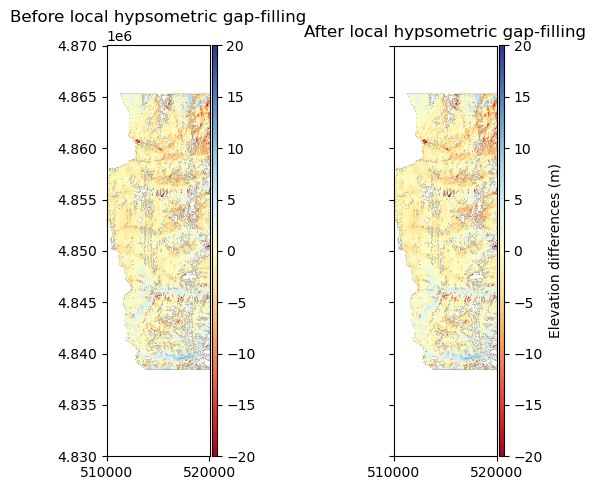

Memory used: 17.39 GB


In [3]:
from datetime import datetime
import psutil


import geoutils as gu
import numpy as np
import matplotlib.pyplot as plt
import xdem

# ==== 1. Load your own data ====
dem_2014 = xdem.DEM("USGS_DEM_1m.tif")         # Reference DEM
dem_1967 = xdem.DEM("c19670803_2_recoregistered.tif")  # DEM with voids
glacier_outlines = gu.Vector("all_featyre_class_for_void_fill.shp")  # Glacier outlines

# ==== NEW: Reproject 1967 DEM to match 2014 ====
dem_1967 = dem_1967.reproject(dem_2014)



# Crop DEMs (optional)
bounds = dem_2014.bounds
dem_2014 = dem_2014.crop(bounds)
dem_1967 = dem_1967.crop(bounds)


dem_1967.data[dem_1967.data == -9999] = np.nan 

# Create dDEM
ddem = xdem.dDEM(
    raster=dem_2014 - dem_1967,
    start_time=datetime(1967, 8, 1),
    end_time=datetime(2014, 8, 1)
)

# Now it's safe to inspect
print("Overlap mask:", np.any(glacier_outlines.create_mask(dem_2014)))
print("NaNs in dDEM:", np.isnan(ddem.data).sum())


print(f"Memory used: {psutil.Process().memory_info().rss / 1024**3:.2f} GB")
# ==== 2. Create the dDEM ====
ddem = xdem.dDEM(
    raster=dem_2014 - dem_1967,
    start_time=datetime(1967, 8, 1),
    end_time=datetime(2014, 8, 1)
)

print(f"Memory used: {psutil.Process().memory_info().rss / 1024**3:.2f} GB")

# ==== 4. Interpolate voids using local hypsometric interpolation ====
ddem_filled = ddem.interpolate(
    method="local_hypsometric",
    reference_elevation=dem_2014,
    mask=glacier_outlines
)


print(f"Memory used: {psutil.Process().memory_info().rss / 1024**3:.2f} GB")
# Wrap as dDEM again
ddem_filled = ddem.copy(new_array=ddem_filled)

print(f"Memory used: {psutil.Process().memory_info().rss / 1024**3:.2f} GB")
# ==== 5. Plot ====
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Before local hypsometric gap-filling")
ddem.plot(cmap='RdYlBu', vmin=-20, vmax=20, ax=ax[0])
ax[1].set_title("After local hypsometric gap-filling")
ddem_filled.plot(cmap='RdYlBu', vmin=-20, vmax=20, ax=ax[1], cbar_title="Elevation differences (m)")
ax[1].set_yticklabels([])
plt.tight_layout()
plt.show()

print(f"Memory used: {psutil.Process().memory_info().rss / 1024**3:.2f} GB")



In [4]:
ddem_filled.save("filled_ddem_localhyps_1967_2014.tif")